In [61]:
# environment: thesisPlayground_pointClouds_env

In [62]:
import h5py
import numpy as np
import open3d as o3d
import pandas as pd
import glob
import os

# Using depths

Hints on how to deal with this problem from:
- https://github.com/apple/ml-hypersim/issues/9

In [63]:
path_metadata_camera_parameters = '/local/home/gmarsich/Desktop/Thesis/0Code_playground/pointClouds_Hypersim/withDepths/metadata_camera_parameters.csv'
base_path = '/local/home/gmarsich/data2TB/Hypersim/evermotion_dataset/scenes'
scene = 'ai_007_008'  # name of the scene, with format ai_VVV_NNN
cam_xx = 'cam_00'

# Get list of image and depth HDF5 files
image_files = sorted(glob.glob(os.path.join(base_path, scene, 'images', 'scene_' + cam_xx + '_final_hdf5', '*.color.hdf5')))
depthEuclidean_files = sorted(glob.glob(os.path.join(base_path, scene, 'images', 'scene_' + cam_xx + '_geometry_hdf5', '*.depth_meters.hdf5')))


### Computations

In [64]:
from decimal import Decimal, getcontext

def get_metadata(path_metadata_camera_parameters, scene):
    # Load the metadata CSV file
    df = pd.read_csv(path_metadata_camera_parameters)
    
    # Filter the DataFrame to get the row corresponding to the specified scene
    scene_row = df[df['scene_name'] == scene]

    return scene_row

# Set the precision for the decimal module
getcontext().prec = 50

scene_row = get_metadata(path_metadata_camera_parameters, scene)

# Extract the specific column value
column_value = scene_row['settings_units_info_meters_scale'].values[0]

# Convert to Decimal for highest precision
decimal_value = Decimal(column_value)

# Print the entire number with full precision
print(decimal_value)


0.0253999996930359996094583863168736570514738559722900390625


### Real code

In [65]:
def get_depths_oneImage(path_file_depths, intWidth = 1024, intHeight = 768, fltFocal = 1438.10734975, factor_assets_to_meters = 0.025399999693035999609458386316873657):

    with h5py.File(path_file_depths, 'r') as file:
        # Access the dataset
        dataset = file['dataset']
        
        # Read the data from the dataset
        data = dataset[:] # len(data) is 768, len(data[0]) is 1024, data[0][0] is the value of the depth

        npyImageplaneX = np.linspace((-0.5 * intWidth) + 0.5, (0.5 * intWidth) - 0.5, intWidth).reshape(1, intWidth).repeat(intHeight, 0).astype(np.float32)[:, :, None]
        npyImageplaneY = np.linspace((-0.5 * intHeight) + 0.5, (0.5 * intHeight) - 0.5, intHeight).reshape(intHeight, 1).repeat(intWidth, 1).astype(np.float32)[:, :, None]
        npyImageplaneZ = np.full([intHeight, intWidth, 1], fltFocal, np.float32)
        npyImageplane = np.concatenate([npyImageplaneX, npyImageplaneY, npyImageplaneZ], 2)

        npyDepth_meters = data / np.linalg.norm(npyImageplane, 2, 2) * fltFocal

        npyDepth_assets = npyDepth_meters / factor_assets_to_meters

        return npyDepth_assets



768
1024


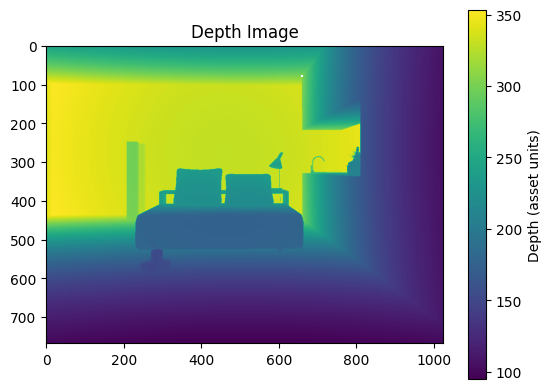

In [66]:
# TEST on one image
import matplotlib.pyplot as plt

depth_files = get_depths_oneImage(depthEuclidean_files[0])

print(len(depth_files))
print(len(depth_files[0]))

plt.imshow(depth_files, cmap='viridis')  # Choose a colormap suitable for depth visualization
plt.colorbar(label='Depth (asset units)')  # Add a colorbar to show depth values
plt.title('Depth Image')  # Add a title to the plot
plt.show()

In [67]:
def generate_point_cloud(files_depths):

    width_pixels = 1024 # TODO maybe should be a parameter
    height_pixels = 768 # TODO maybe should be a parameter

    fx = 1438.10734975 # TODO maybe should be a parameter
    fy = fx

    cam_coo_list = []
    point_clouds = []

    for depths in files_depths:

        cam_coo = []

        for y in range(height_pixels):
            for x in range(width_pixels):
                z_cam = - depths[y][x] # the - is because of the coordinate system
                x_cam = (x - width_pixels/2) / fx * (-z_cam) 
                y_cam = -(y - height_pixels/2) / fy * (-z_cam) # TODO maybe something to change the coordinates should be done
                xyz_cam = [x_cam, y_cam, z_cam] # if you multiply z_cam0 by 1000 the rendering is a little bit nicer

                cam_coo.append(xyz_cam)

        cam_coo_list.append(cam_coo)


    return cam_coo_list

    #     # Create Open3D PointCloud object and add it to the list
    #     pcd = o3d.geometry.PointCloud()
    #     pcd.points = o3d.utility.Vector3dVector(cam_coo)
    #     point_clouds.append(pcd)

    # return point_clouds

In [68]:
depth_files_list = [depth_files]

cam_coo_list = generate_point_cloud(depth_files_list)

In [69]:
len(cam_coo_list[0][0])

3

In [70]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(cam_coo_list[0])

In [71]:
o3d.visualization.draw_geometries([pcd])

# Other things not relevant

In [72]:
def get_depths(path_list):
    '''Each element of depth_files will be a representation of an image'''
    
    depth_files = []
    for i in range(path_list):
        depth_files[i] = get_depths_oneImage(path_list[i])

    return depth_files


In [73]:
def get_intrinsics_from_metadata_COMPLETE(path_metadata, scene_row):
    """
    Load camera metadata from a CSV file and compute the intrinsic matrix considering tilt-shift parameters.

    Parameters:
        path_metadata (str): Path to the metadata CSV file.
        scene_name (str): Name of the scene to analyze.

    Returns:
        np.ndarray: The updated intrinsic matrix K.
    """

    # Load the metadata CSV file
    df = pd.read_csv(path_metadata)
    
    # Filter the DataFrame to get the row corresponding to the specified scene
    scene_row = df[df['scene_name'] == scene_row]
    
    if scene_row.empty:
        raise ValueError(f"Scene '{scene_row}' not found in the metadata.")
    
    # Use the first matching row
    scene_row = scene_row.iloc[0]

    # Extract the necessary parameters from the metadata
    img_width = scene_row["settings_output_img_width"]
    img_height = scene_row["settings_output_img_height"]
    focal_length = scene_row["camera_physical_focal_length"] # remark that it's in millimeters
    sensor_width = scene_row["camera_physical_film_width"] # remark that it's in millimeters

    # Calculate fx and fy using the focal length and sensor width
    fx = focal_length / sensor_width * img_width # conversion mm -> pixels
    fy = fx  # Assuming square pixels

    # Calculate the principal point (cx, cy) considering horizontal and vertical shifts
    cx = img_width / 2 # TODO FOR TILT-SHIFT should add: + scene_row["camera_physical_horizontal_shift"] but I am not sure about the unit of measure
    print('img_width: ', img_width)
    print('camera_physical_horizontal_shift":', scene_row["camera_physical_horizontal_shift"])
    cy = img_height / 2 # TODO FOR TILT-SHIFT should add: + scene_row["camera_physical_lens_shift"] but I am not sure about the unit of measure
    print('img_height : ', img_height )
    print('camera_physical_lens_shift":', scene_row["camera_physical_lens_shift"])

    # Construct the intrinsic matrix. Everything is in pixels
    intrinsic_matrix = np.array([
        [fx, 0, cx],
        [0, fy, cy],
        [0, 0, 1]
    ])
    
    return intrinsic_matrix



def load_hdf5_data(image_files, depth_files):
    """
    Load images and depth data from multiple HDF5 files.
    
    Parameters:
        image_files (list): List of paths to the HDF5 files containing images.
        depth_files (list): List of paths to the HDF5 files containing depth maps.
    
    Returns:
        images (list): List of images.
        depths (list): List of depth maps.
    """

    images = []
    depths = []

    for image_file, depth_file in zip(image_files, depth_files):
        with h5py.File(image_file, 'r') as f:
            images.append(np.array(f['dataset']))  # Adjust the key according to your HDF5 structure

        with h5py.File(depth_file, 'r') as f:
            depths.append(np.array(f['dataset']))  # Adjust the key according to your HDF5 structure

    return images, depths



def generate_point_cloud_OLD(images, depths, intrinsic_matrix): # extrinsic_matrices is not useful here, but will be used afterwards, having more images to put together
    """
    Parameters:
        images (list): List of images.
        depths (list): List of depth maps.
        intrinsic_matrix (np.ndarray): Intrinsic matrix of the camera.

    Returns:
        point_clouds (list): List of Open3D PointCloud objects.
    """
    point_clouds = []

    for image, depth in zip(images, depths):

        # Get the image dimensions
        h, w = depth.shape

        # Create a mesh grid of pixel coordinates
        u, v = np.meshgrid(np.arange(w), np.arange(h))
        u = u.flatten()
        v = v.flatten()

        # Get the corresponding depth values
        z = depth.flatten()

        # Filter out points with zero depth
        valid = z > 0
        u = u[valid]
        v = v[valid]
        z = z[valid]

        # Convert pixel coordinates to normalized image coordinates; create 3D points in the camera coordinate system
        x = (u - intrinsic_matrix[0, 2]) / intrinsic_matrix[0, 0] * z
        y = (v - intrinsic_matrix[1, 2]) / intrinsic_matrix[1, 1] * z

        # Stack the coordinates into a single array
        points = np.vstack((x, y, z)).T


        # The commented things will be useful when dealing with more than one image

        # # Apply extrinsic transformation
        # ones = np.ones((points.shape[0], 1))
        # points_homogeneous = np.hstack((points, ones))
        # points_transformed = (extrinsic_matrix @ points_homogeneous.T).T[:, :3]

        # Create Open3D PointCloud object and add it to the list
        pcd = o3d.geometry.PointCloud()
        #pcd.points = o3d.utility.Vector3dVector(points_transformed)
        pcd.points = o3d.utility.Vector3dVector(points) # to be deleted when having more than one image
        point_clouds.append(pcd)

    return point_clouds



def generate_point_cloud(images, depths, intrinsic_matrix):
    """
    Parameters:
        images (list): List of images.
        depths (list): List of depth maps.
        intrinsic_matrix (np.ndarray): Intrinsic matrix of the camera.

    Returns:
        point_clouds (list): List of Open3D PointCloud objects.
    """
    point_clouds = []

    for image, depth in zip(images, depths):

        # Get the image dimensions
        h, w = depth.shape

        # Create a mesh grid of pixel coordinates
        u, v = np.meshgrid(np.arange(w), np.arange(h))
        u = u.flatten()
        v = v.flatten()

        # Get the corresponding depth values
        z = depth.flatten()

        # Filter out points with zero depth
        valid = z > 0
        u = u[valid]
        v = v[valid]
        z = z[valid]

        # Convert pixel coordinates to normalized image coordinates; create 3D points in the camera coordinate system
        x = (u - intrinsic_matrix[0, 2]) / intrinsic_matrix[0, 0] * z
        y = (v - intrinsic_matrix[1, 2]) / intrinsic_matrix[1, 1] * z

        # Stack the coordinates into a single array
        points = np.vstack((x, y, z)).T


        # The commented things will be useful when dealing with more than one image

        # # Apply extrinsic transformation
        # ones = np.ones((points.shape[0], 1))
        # points_homogeneous = np.hstack((points, ones))
        # points_transformed = (extrinsic_matrix @ points_homogeneous.T).T[:, :3]

        # Create Open3D PointCloud object and add it to the list
        pcd = o3d.geometry.PointCloud()
        #pcd.points = o3d.utility.Vector3dVector(points_transformed)
        pcd.points = o3d.utility.Vector3dVector(points) # to be deleted when having more than one image
        point_clouds.append(pcd)

    return point_clouds



def render_point_cloud(point_cloud):

    pcd = point_cloud

    # Create a visualization window
    vis = o3d.visualization.Visualizer()

    # Add the point cloud to the visualization window
    vis.create_window()
    vis.add_geometry(pcd)

    # Set the render options (optional)
    render_options = vis.get_render_option()
    render_options.point_size = 2  # Adjust the size of the points

    # Render the visualization
    vis.run()

    # Close the visualization window
    vis.destroy_window()


In [74]:




# # Ensure the number of image and depth files match
# if len(image_files) != len(depth_files):
#     raise ValueError("The number of image files and depth files do not match.")

In [75]:
# Get the intrinsic matrix for the scene
intrinsics = get_intrinsics_with_tilt_shift_COMPLETE(path_metadata, scene)
print("Intrinsic Matrix for the scene:")
print(intrinsics)

# Load images and depth data
images, file_depths = load_hdf5_data(image_files, position_files)

# Generate point clouds for each view
point_clouds = generate_point_cloud(images, file_depths, intrinsics, 1) # here extrinsics_matrices = 1 because it is not used, the value 1 is random

cloud = point_clouds[0]
print(cloud)

render_point_cloud(point_clouds[0])

NameError: name 'get_intrinsics_with_tilt_shift_COMPLETE' is not defined